## Imports

In [1]:
# Install necessary packages
! pip install -q xgboost 
! pip install -q imbalanced-learn --user
! pip install -q lightgbm

In [26]:
# Import packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import  recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Input

In [3]:
# Import train and test data
train_data = pd.read_csv('data/df_train.csv')
test = pd.read_csv('data/df_predict.csv')

In [4]:
# Check the data
train_data.head()

,id,app_or_website,customer_collects,customer_segmentation,is_a_repeat_order,lead_time,n_customer_notes,n_items_above_quantity_10,n_listed_addresses,n_listed_payment_methods,n_previous_cancelled_orders,n_previous_completed_orders,n_small_items,payment_type,slot_date,store_number,total_price,status
0,TID32798,website,0.0,group_1,0.0,12.421322,0.0,2.0,1.0,1.0,0.0,0.0,0.0,debit,2018-09-25 00:00:00,id_58,69.243353,Not_Canceled
1,TID29290,app,NaN,group_1,0.0,39.849103,0.0,0.0,1.0,2.0,0.0,0.0,2.0,credit,2018-07-22 00:00:00,id_29,59.937542,Not_Canceled
2,TID16941,website,0.0,group_1,0.0,1.608750,1.0,0.0,1.0,2.0,0.0,0.0,1.0,debit,2019-07-12 00:00:00,id_4,84.391362,Not_Canceled
3,TID02831,app,0.0,group_1,0.0,116.432876,0.0,2.0,1.0,1.0,0.0,0.0,1.0,debit,2019-02-05 00:00:00,id_19,46.689214,Not_Canceled
4,TID22422,app,NaN,group_1,0.0,71.181542,1.0,0.0,1.0,2.0,0.0,0.0,3.0,credit,2019-04-17 00:00:00,id_8,72.215528,Not_Canceled


In [5]:
# Check database shape
train_data.shape

(4000, 18)

In [6]:
# Check whether id column is unique or not
train_data['id'].nunique()

4000

In [7]:
# Set the 'id' column as the new index
train_data = train_data.set_index('id')

## Splitting data       

I used a time-based split instead of a random split to respect the chronological order of the data. This prevents data leakage from future observations into the training set, ensures our evaluation mimics real-world deployment (predicting future from past)


In [8]:
# Converting slot_date to datetime format
train_data['slot_date'] = pd.to_datetime(train_data['slot_date'])

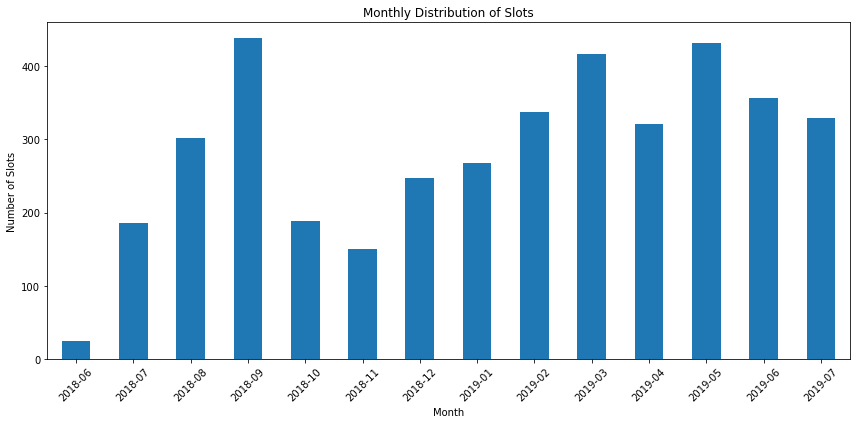

In [9]:
# Extract month and count occurrences
monthly_counts = train_data['slot_date'].dt.to_period('M').value_counts().sort_index()

# Plot the monthly counts
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar')
plt.title('Monthly Distribution of Slots')
plt.xlabel('Month')
plt.ylabel('Number of Slots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The distribution of slot dates across months shows a clear temporal ordering in the dataset. To mimic the real-world scenario where future outcomes must be predicted based only on past information I adopted a time-based data split rather than a random split. This approach prevents information leakage from future records into the training set, ensures that model evaluation reflects realistic deployment conditions, and allows us to capture potential temporal trends or seasonality in the data.

In [10]:
# Sorting by date
train_data = train_data.sort_values(by='slot_date')

In [11]:
# Calculate the split point (80% of the data)
split_index = int(len(train_data) * 0.8)

# Split the data
train_df = train_data.iloc[:split_index]
test_df = train_data.iloc[split_index:]

# Check the sizes of the resulting DataFrames
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 3200
Test set size: 800


In [12]:
y_train = train_df['status']
X_train = train_df.drop(columns='status', axis=1)
y_val = test_df['status']
X_val = test_df.drop(columns='status', axis=1)

## Missing values

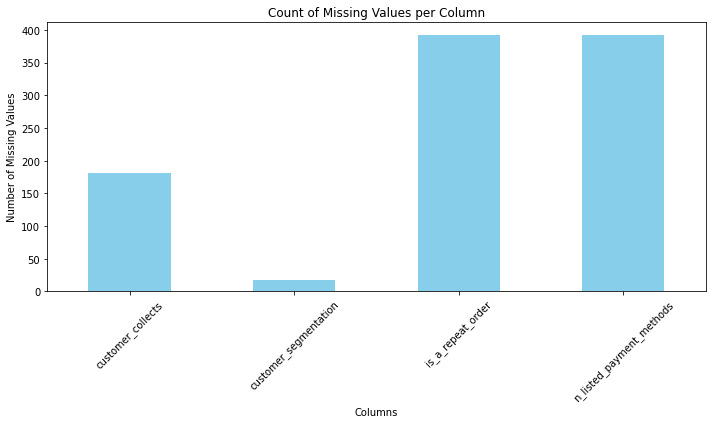

In [13]:
# Count the number of missing values in each column
missing_counts = train_data.isnull().sum()
# Filter for columns that have at least one missing value
missing_columns = missing_counts[missing_counts > 0]
# Check if there are any columns with missing values to plot
if not missing_columns.empty:
    # Create the bar plot for only the columns with missing values
    plt.figure(figsize=(10, 6))
    missing_columns.plot(kind='bar', color='skyblue')
    plt.title('Count of Missing Values per Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the DataFrame.")

In [14]:
most_frequent_segment = X_train['customer_segmentation'].mode()[0]
def handle_missing_values(df, frequent_segment):
    """
    Handles missing values in the dataset using simple, consistent rules.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the features.
    frequent_segment : str
        The most frequent value (mode) from the 'customer_segmentation' 
        column in the training data. This ensures categorical imputation 
        is consistent across train/validation/test.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with missing values imputed:
          - 'customer_collects', 'is_a_repeat_order', 'n_listed_payment_methods'
            → filled with 0 (interpreted as "no activity" or "none").
          - 'customer_segmentation'
            → filled with the most frequent segment value.
    """
    # List of columns to fill
    columns_to_fill = ['customer_collects', 'is_a_repeat_order', 'n_listed_payment_methods']
    # Fill missing values with 0 in the specified columns
    df[columns_to_fill] = df[columns_to_fill].fillna(0)
    # Fill missing values in the customer_segmentation column with the mode
    df['customer_segmentation'].fillna(frequent_segment, inplace=True)
    return df
X_train = handle_missing_values(X_train, most_frequent_segment)

## Feature engineering

In [15]:
def feature_engineering(df):
    """
    Generates additional features from raw input data.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing original features.

    Returns
    -------
    pandas.DataFrame
        DataFrame with engineered features and original columns (except slot_date).
    """
    # Date-based features
    if 'slot_date' in df.columns:
        slot_dt = pd.to_datetime(df['slot_date'], errors='coerce')
        df['slot_month'] = slot_dt.dt.month
        df['slot_dow'] = slot_dt.dt.dayofweek
    df = df.drop(columns=['slot_date'], axis=1)

    # Ratio-based behavioral features
    df['cancel_rate_prev'] = df['n_previous_cancelled_orders'] / (1 + df['n_previous_completed_orders'])
    df['basket_size_per_address'] = df['n_small_items'] / (1 + df['n_listed_addresses'])
    return df
X_train = feature_engineering(X_train)

## Outliers

In [ ]:
# Checking data types
X_train.dtypes

app_or_website                  object
customer_collects              float64
customer_segmentation           object
is_a_repeat_order              float64
lead_time                      float64
n_customer_notes               float64
n_items_above_quantity_10      float64
n_listed_addresses             float64
n_listed_payment_methods       float64
n_previous_cancelled_orders    float64
n_previous_completed_orders    float64
n_small_items                  float64
payment_type                    object
store_number                    object
total_price                    float64
slot_month                       int64
slot_dow                         int64
cancel_rate_prev               float64
basket_size_per_address        float64
dtype: object

In [ ]:
# Identify data types
cat_cols = [c for c in X_train.columns if X_train[c].dtype.kind in "OUSb"]
num_cols = [c for c in X_train.columns if c not in cat_cols]
len(cat_cols), len(num_cols)

(4, 15)

In [ ]:
def check_outliers(df, cols, method="IQR", plot=False):
    """
    Detect outliers in specified numeric columns using IQR or z-score.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset containing numeric features.
    cols : list of str
        List of column names to check for outliers.
    method : str, default="IQR"
        Outlier detection method:
          - "IQR": Interquartile Range (Q1 - 1.5*IQR, Q3 + 1.5*IQR).
          - "zscore": Standard score method (|z| > 3 considered outlier).
    plot : bool, default=False
        If True, draw boxplots for each column to visualize distribution
        and potential outliers.

    Returns
    -------
    dict
        A dictionary mapping each column name to the number of detected outliers.
    """
    outlier_summary = {}
    for col in cols:
        series = df[col].dropna()

        # Outlier detection using IQR method
        if method == "IQR":
            Q1, Q3 = series.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            outliers = series[(series < lower) | (series > upper)]
        elif method == "zscore":
            z = (series - series.mean()) / series.std()
            outliers = series[abs(z) > 3]
        outlier_summary[col] = len(outliers)
        
        # Optional: plot boxplot for visual inspection
        if plot:
            plt.figure()
            series.plot(kind="box")
            plt.title(f"Boxplot for {col}")
            plt.show()
    return outlier_summary



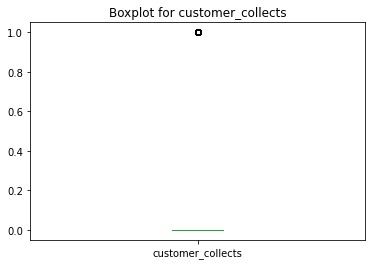

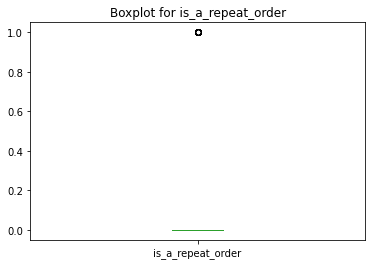

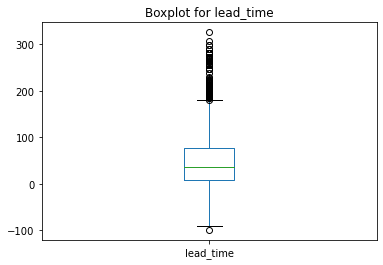

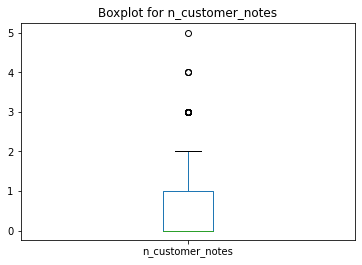

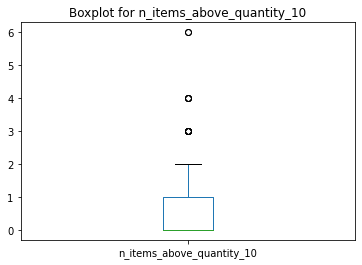

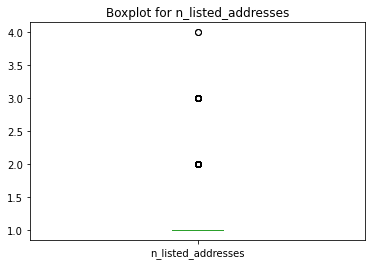

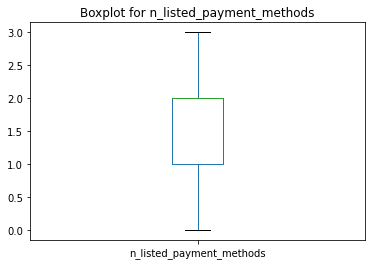

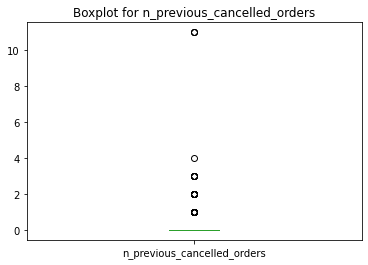

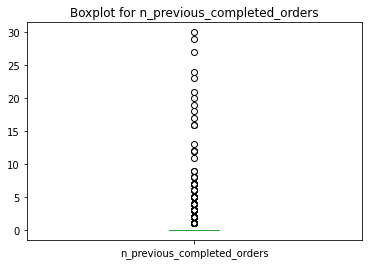

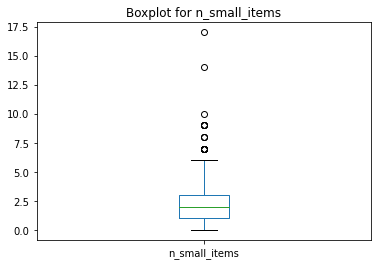

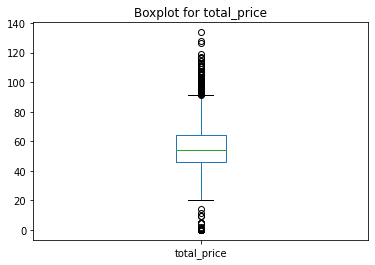

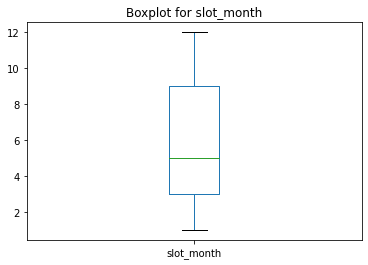

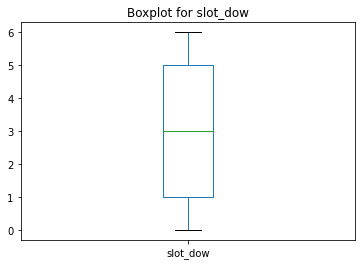

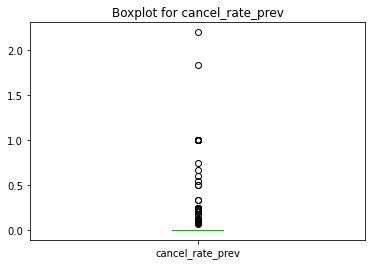

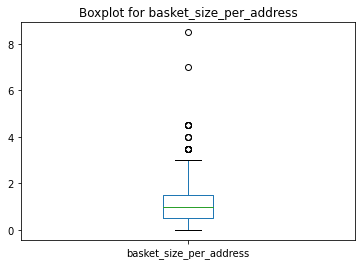

{'customer_collects': 103, 'is_a_repeat_order': 38, 'lead_time': 123, 'n_customer_notes': 63, 'n_items_above_quantity_10': 13, 'n_listed_addresses': 184, 'n_listed_payment_methods': 0, 'n_previous_cancelled_orders': 58, 'n_previous_completed_orders': 114, 'n_small_items': 20, 'total_price': 196, 'slot_month': 0, 'slot_dow': 0, 'cancel_rate_prev': 58, 'basket_size_per_address': 18}


In [19]:
outlier_counts = check_outliers(X_train, num_cols, method="IQR", plot=True)
print(outlier_counts)

In [20]:
def fit_caps(df_train, cols, upper_quantile=0.99, lower_quantile=None):
    """
    Fit capping thresholds on training data.
    """
    caps = {}
    for col in cols:
        thresholds = {}
        if lower_quantile is not None:
            thresholds["lower"] = df_train[col].quantile(lower_quantile)
        thresholds["upper"] = df_train[col].quantile(upper_quantile)
        caps[col] = thresholds
    return caps

def apply_caps(df, caps):
    """
    Apply pre-computed caps to a dataframe.
    """
    df_capped = df.copy()
    for col, thresholds in caps.items():
        if "lower" in thresholds:
            df_capped[col] = np.where(df_capped[col] < thresholds["lower"], thresholds["lower"], df_capped[col])
        if "upper" in thresholds:
            df_capped[col] = np.where(df_capped[col] > thresholds["upper"], thresholds["upper"], df_capped[col])
    return df_capped

`total_price`, `lead_time`, `n_listed_payment_methods`,`n_listed_addresses`,
    `n_previous_completed_orders` were chosen for outlier handling.
- `total_price`: Highest outlier count (196), strongly influences model stability.
- `lead_time`: Large number of extreme values (123), may distort temporal features.
- `n_listed_addresses`: High outlier count (184), risk of skewing address-based features. 
- `n_previous_completed_orders`: Substantial outliers (114), critical for capturing 
  customer history without letting extreme values dominate.

In [23]:
# getting columns to handle outliers
cols_to_cap = ["total_price", "lead_time", "n_listed_addresses",
    "n_previous_completed_orders"]

# Fit caps on training set only
caps = fit_caps(X_train, cols_to_cap, upper_quantile=0.97)


In [24]:
# Apply caps on train data
X_train_capped = apply_caps(X_train, caps)

## Scaling

In [30]:
# Create a StandardScaler instance
scaler = StandardScaler()

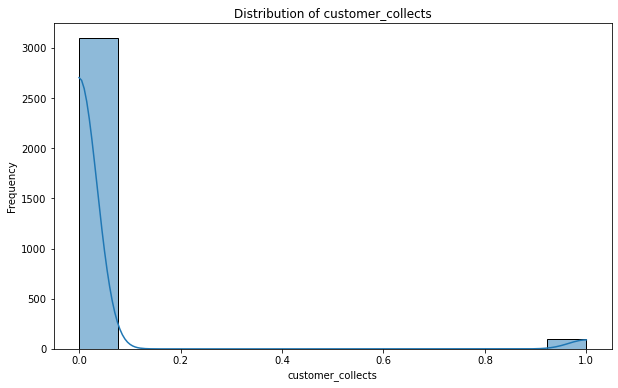

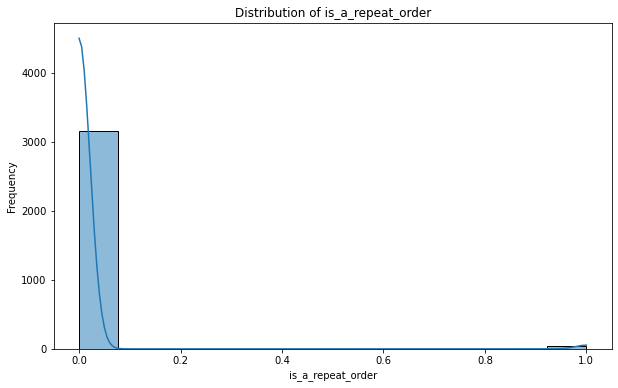

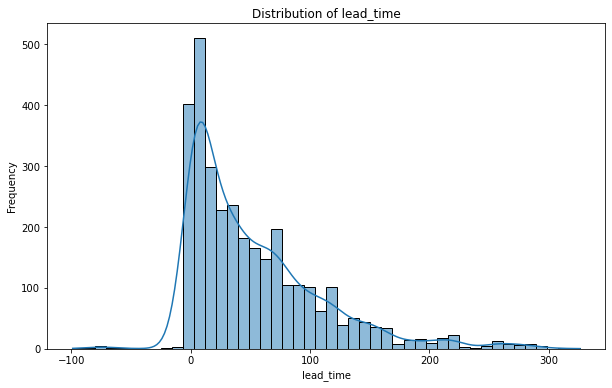

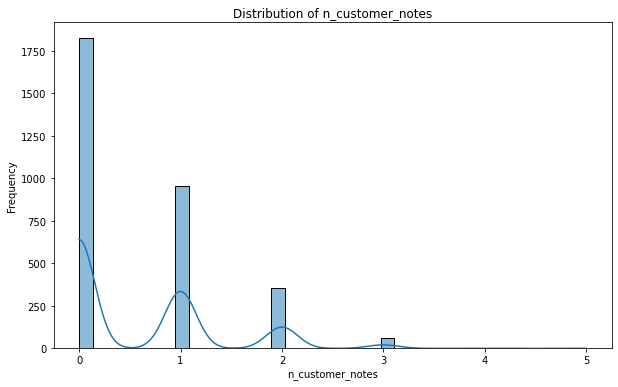

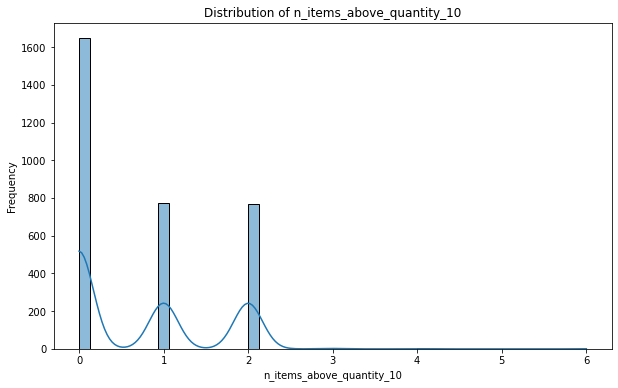

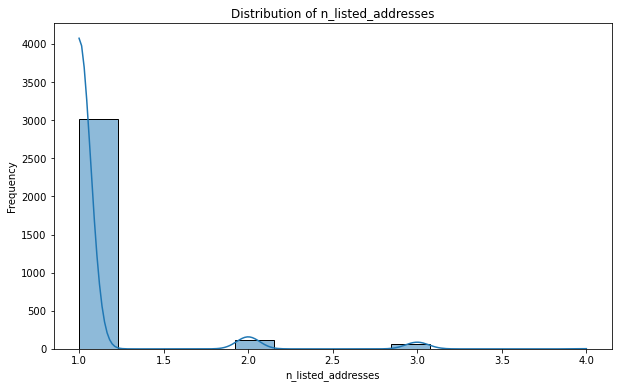

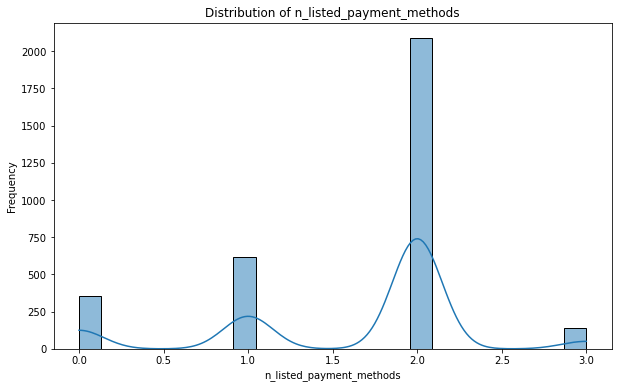

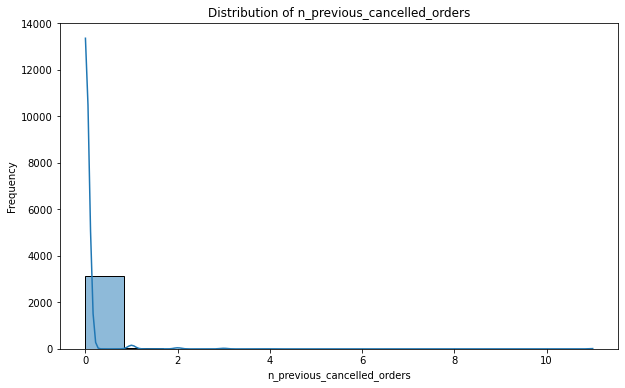

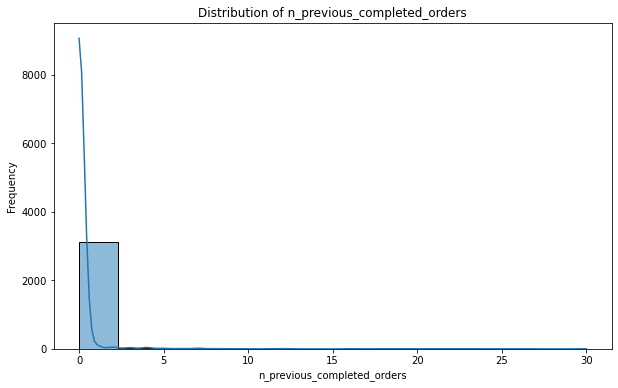

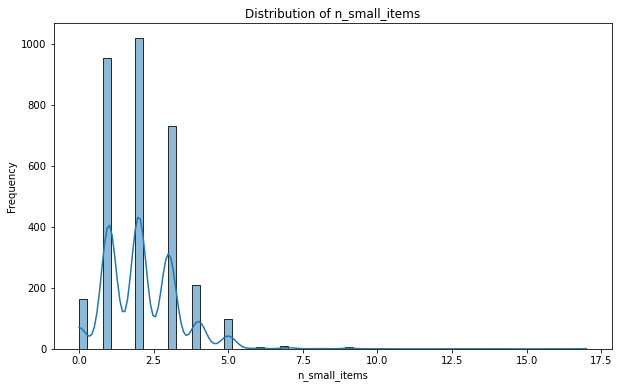

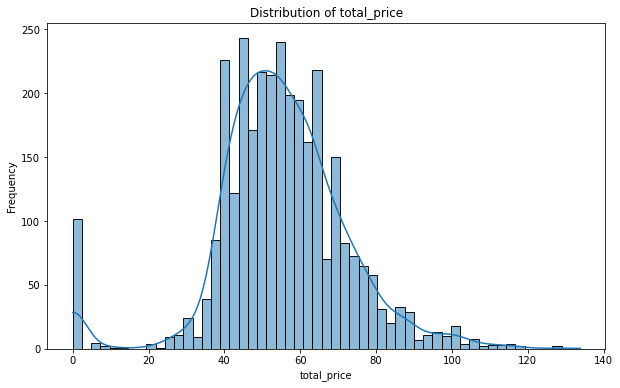

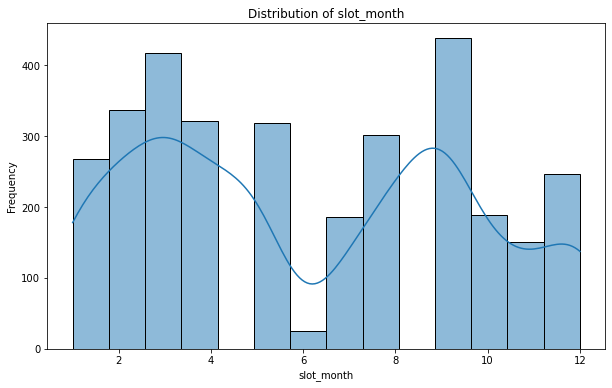

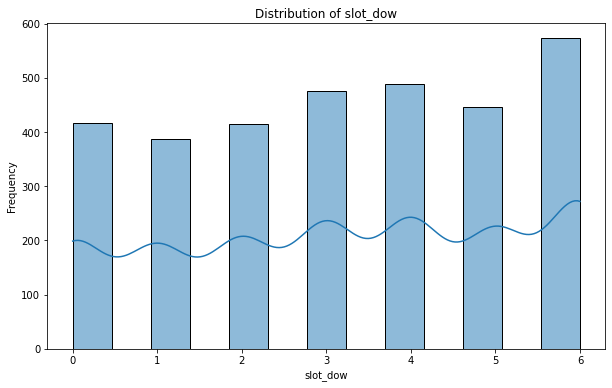

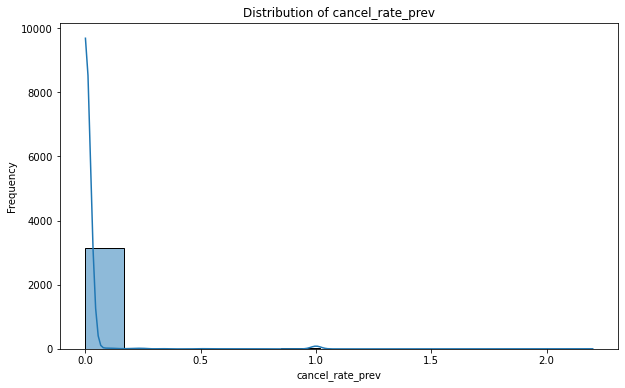

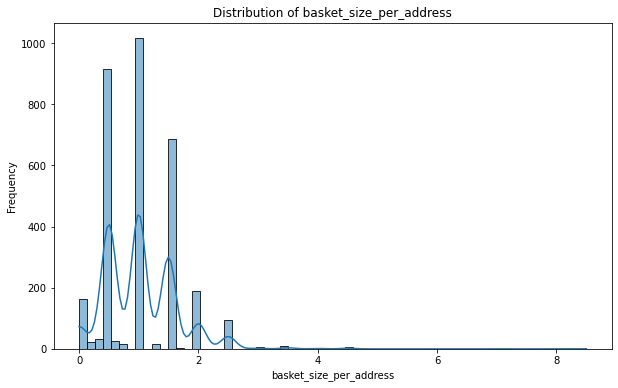

In [31]:
def num_frequency(X_train, num_cols):
    """Plot frequency distributions for numeric features."""
    for col in num_cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(X_train[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
num_frequency(X_train, num_cols)

Based on the frequency distribution plots of numeric features, it is evident that total_price and lead_time are continuous-valued variables. Their histograms show a wide range of values without natural discrete groupings. So seleted those two columns for scaling.

In [32]:
# List the columns to be scaled
columns_to_scale = ['total_price', 'lead_time']

In [33]:
# Fit the scaler on the training data and transform it
X_train_capped[columns_to_scale] = scaler.fit_transform(X_train_capped[columns_to_scale])

## Columns to encode

In [34]:
def identify_categorical_types(df):
    """
    Identifies binary and multi-class categorical columns in a DataFrame.
    """
    binary_cols = []
    multiclass_cols = []

    # Select columns with 'object' or 'category' data types
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        num_unique = df[col].nunique()
        if num_unique == 2:
            binary_cols.append(col)
        else:
            multiclass_cols.append(col)

    return binary_cols, multiclass_cols


# Run the function
binary, multiclass = identify_categorical_types(X_train_capped)

print(f"Binary categorical columns: {binary}")
print(f"Multi-class categorical columns: {multiclass}")

Binary categorical columns: ['payment_type']
Multi-class categorical columns: ['app_or_website', 'customer_segmentation', 'store_number']


In [35]:
def distribution_of_cat(multiclass):
    """Plot frequency distributions for categorical features."""
    for column in multiclass:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, data=X_train, order=X_train[column].value_counts().index)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

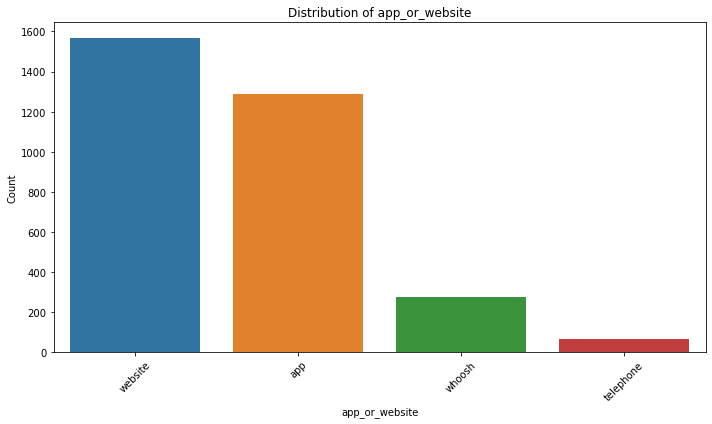

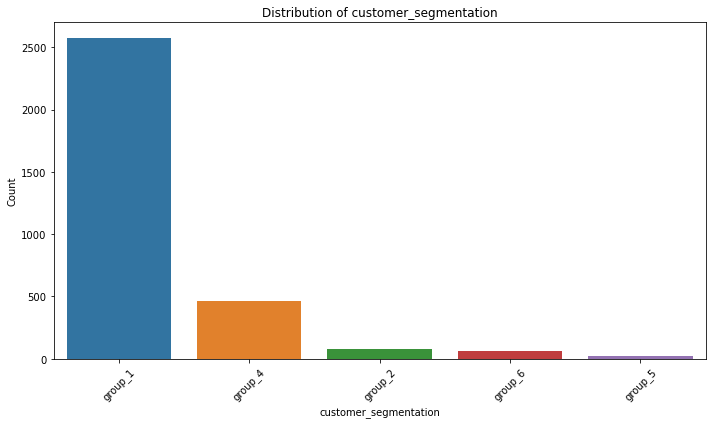

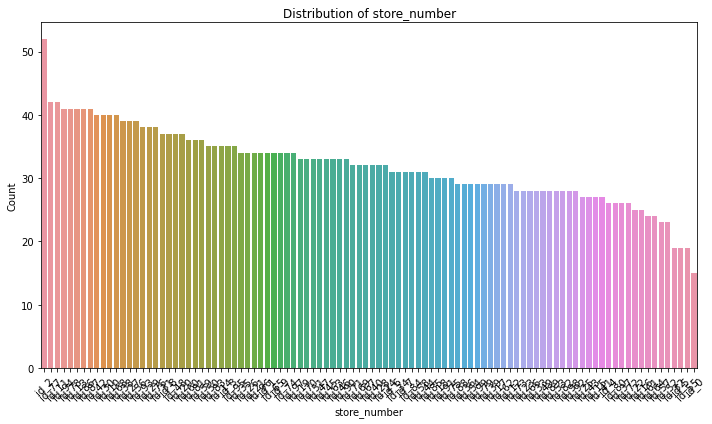

In [36]:
distribution_of_cat(multiclass)

#### Encoding Strategy for Categorical Features

`app_or_website` and `customer_segmentation`
These features have only a small number of distinct categories. One-Hot Encoding is applied because:

   - It creates a separate binary column for each category, which is efficient when the number of categories is low.

   - Preserves interpretability of categories.

   - Avoids imposing an ordinal relationship where none exists.

`store_number`
This feature has many distinct values (high cardinality). One-Hot Encoding here would create too many sparse columns and lead to dimensionality issues. Instead, Frequency Encoding is applied because:

   - It replaces each category with its occurrence count (or normalized frequency) in the dataset.

   - Efficiently handles high-cardinality categorical variables without expanding feature space.

   - Retains information about the relative prevalence of categories.

In [40]:
# Calculate the frequency of each store number
frequency_map = X_train['store_number'].value_counts(normalize=True).to_dict()

In [41]:
# Define the mapping dictionary for binary columns and target
payment_mapping = {'debit': 1, 'credit': 0}
target_mapping = {'Canceled':1, 'Not_Canceled':0}

In [42]:
# One-hot encode the specified columns
df_encoded = pd.get_dummies(X_train_capped, columns=['app_or_website', 'customer_segmentation'])

# Map the frequencies back to the original column
df_encoded['store_number'] = df_encoded['store_number'].map(frequency_map)
# Apply the mapping to the 'payment_type' column
df_encoded['payment_type'] = df_encoded['payment_type'].map(payment_mapping)

y_train = y_train.map(target_mapping)

## Class Imbalance

,dtype
app_or_website,object
customer_collects,float64
customer_segmentation,object
is_a_repeat_order,float64
lead_time,float64
n_customer_notes,float64
n_items_above_quantity_10,float64
n_listed_addresses,float64
n_listed_payment_methods,float64
n_previous_cancelled_orders,float64


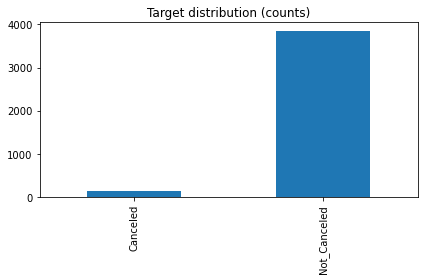

Not_Canceled    0.963
Canceled        0.037
Name: fraction, dtype: float64

In [43]:
# Quick schema + missingness
from matplotlib import pyplot as plt

display(train_data.dtypes.to_frame('dtype'))

ax = train_data['status'].value_counts().sort_index().plot(kind='bar')
plt.title('Target distribution (counts)')
plt.tight_layout()
plt.show()
train_data['status'].value_counts(normalize=True).rename('fraction')

The target distribution is highly imbalanced, with only 3.7% Canceled cases. To address this, I apply SMOTE, which synthesizes new minority samples, balancing the dataset and improving the model’s ability to detect cancellations by enhancing recall and F1 score.

In [44]:
# Create an instance of SMOTE
smote = SMOTE(random_state=42)

In [45]:
# Fit and apply the transform to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(df_encoded, y_train)

C:\Users\Pranavi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Process validation data

In [46]:
def process_data(df, df_y, most_frequent_segment, columns_to_scale, frequency_map, payment_mapping, target_mapping):
    """
    End-to-end preprocessing pipeline for preparing raw data before model training or inference.

    Parameters
    ----------
    df : pandas.DataFrame
        Input feature dataset.
    df_y : pandas.Series or None
        Target labels. If None, labels will be skipped (useful for test/inference data).
    most_frequent_segment : str
        Mode value of 'customer_segmentation' used for imputing missing categorical values.
    columns_to_scale : list of str
        Numeric columns to be scaled with a pre-fitted scaler.
    frequency_map : dict
        Mapping from store_number categories to their frequency-encoded values.
    payment_mapping : dict
        Mapping of payment_type categories to numeric values.
    target_mapping : dict
        Mapping of target labels to numeric values.

    Returns
    -------
    encoded : pandas.DataFrame
        Preprocessed feature dataset, ready for model input.
    df_y : pandas.Series or None
        Processed target labels, mapped to numeric form if provided.
    """

    # Handle missing values in numeric and categorical columns
    df = handle_missing_values(df, most_frequent_segment)

    # Perform feature engineering (e.g., date-based and ratio features)
    df = feature_engineering(df)

    # Cap extreme values (outlier handling)
    df_capped = apply_caps(df, caps)

    # Scale numeric columns using a pre-fitted scaler
    df_capped[columns_to_scale] = scaler.transform(df_capped[columns_to_scale])

    # One-hot encode low-cardinality categorical variables
    encoded = pd.get_dummies(df_capped, columns=['app_or_website', 'customer_segmentation'])

    # Frequency encode high-cardinality categorical variable
    encoded['store_number'] = encoded['store_number'].map(frequency_map)

    # Map payment_type categories to predefined numeric codes
    encoded['payment_type'] = encoded['payment_type'].map(payment_mapping)

    # Map target labels to numeric form, if labels are provided
    if df_y is not None:
        df_y = df_y.map(target_mapping)

    return encoded, df_y


In [48]:
X_val_processed, y_val_processed = process_data(X_val, y_val, most_frequent_segment, columns_to_scale, frequency_map, payment_mapping, target_mapping)

## Modelling

### Base line model

In [50]:
# Instantiate a Logistic Regression model with a fixed random seed for reproducibility
lr_model = LogisticRegression(random_state=42)

# Fit the model on the resampled training data 
lr_model.fit(X_train_resampled, y_train_resampled)

# Generate class predictions on the validation set
lr_preds = lr_model.predict(X_val_processed)

# Generate predicted probabilities for the positive class (used later for threshold tuning/ensembling)
lr_probs = lr_model.predict_proba(X_val_processed)[:, 1]

# Compute the macro F1 score, which treats both classes equally regardless of imbalance
lr_f1m = f1_score(y_val_processed, lr_preds, average='macro')

# Compute recall (sensitivity) for the positive class: how many actual positives were correctly identified
lr_recall = recall_score(y_val_processed, lr_preds)

# Print evaluation results
print(f"Recall score: {lr_recall:.2f}")
print(f"f1_score: {lr_f1m:.2f}")

Recall score: 0.62
f1_score: 0.57


C:\Users\Pranavi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [52]:
# Instantiate a Random Forest model with a fixed random seed for reproducibility
rf_model = RandomForestClassifier(random_state=42)
# Fit the model on the resampled training data 
rf_model.fit(X_train_resampled, y_train_resampled)

# Generate class predictions on the validation set
rf_preds = rf_model.predict(X_val_processed)

# Generate predicted probabilities for the positive class (used later for threshold tuning/ensembling)
rf_probs = rf_model.predict_proba(X_val_processed)[:, 1]

# Compute the macro F1 score, which treats both classes equally regardless of imbalance
rf_f1m = f1_score(y_val_processed, rf_preds, average='macro')

# Compute recall (sensitivity) for the positive class: how many actual positives were correctly identified
rf_recall = recall_score(y_val_processed, rf_preds)

print(f"Recall score: {rf_recall:.2f}")
print(f'f1_score: {rf_f1m:.2f}')

Recall score: 0.32
f1_score: 0.64


### XGB Model

In [54]:
# Instantiate a XGBoost model with a fixed random seed for reproducibility
xgb_model =  xgb.XGBClassifier(random_state=42)

# Fit the model on the resampled training data 
xgb_model.fit(X_train_resampled, y_train_resampled)

# Generate predicted probabilities for the positive class (used later for threshold tuning/ensembling)
xgb_preds = xgb_model.predict(X_val_processed)

# Generate class predictions on the validation set
xgb_f1m = f1_score(y_val_processed, xgb_preds, average='macro')

# Compute recall (sensitivity) for the positive class: how many actual positives were correctly identified
xgb_recall = recall_score(y_val_processed, xgb_preds)

# Print evaluation results
print(f"Recall score: {xgb_recall:.2f}")
print(f'f1_score: {xgb_f1m:.2f}')

Recall score: 0.45
f1_score: 0.66


### Light GBM

In [55]:
# Instantiate the LightGBM classifier
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Fit the model on the resampled training data 
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Generate class predictions on the validation set
lgbm_preds = lgbm_model.predict(X_val_processed)

# Generate predicted probabilities for the positive class (used later for threshold tuning/ensembling)
lgbm_probs = lgbm_model.predict_proba(X_val_processed)[:, 1]

# Compute the macro F1 score, which treats both classes equally regardless of imbalance
lgbm_f1m = f1_score(y_val_processed, lgbm_preds, average='macro')

# Compute recall (sensitivity) for the positive class: how many actual positives were correctly identified
lgbm_recall = recall_score(y_val_processed, lgbm_preds)

# Print evaluation results
print(f"Recall score: {lgbm_recall:.2f}")
print(f'f1_score: {lgbm_f1m:.2f}')

[LightGBM] [Info] Number of positive: 3099, number of negative: 3099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 6198, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Recall score: 0.49
f1_score: 0.69


### Model Comparison

In [59]:
# Model results
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Recall": [0.62, 0.32, 0.45, 0.49],
    "F1 Score": [0.57, 0.64, 0.66, 0.69]
}

# Create DataFrame
results_df = pd.DataFrame(results)

In [60]:
results_df

,Model,Recall,F1 Score
0,Logistic Regression,0.62,0.57
1,Random Forest,0.32,0.64
2,XGBoost,0.45,0.66
3,LightGBM,0.49,0.69



From the results, it is observed that Logistic Regression achieves the highest recall (0.62), indicating its strength in correctly identifying minority class instances. Conversely, LightGBM yields the highest F1 score (0.69), reflecting a better balance between precision and recall across classes.

### Hyper parameter tuning

In [56]:
# Define the model
lgbm_hy = lgb.LGBMClassifier(random_state=42)
# Define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, 1000],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 5, 10, 15],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up the randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=lgbm_hy,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    scoring='f1_macro',
    cv=cv,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1, # Use all available cores
    random_state=42
)

# Run the search on your training data
random_search.fit(X_train_resampled, y_train_resampled)
print("Best hyperparameters found: ", random_search.best_params_)
print("Best F1-score: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 3099, number of negative: 3099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 6198, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [58]:
best_model = random_search.best_estimator_
best_model_preds = best_model.predict(X_val_processed)
best_model_f1m = f1_score(y_val_processed, best_model_preds, average='macro')

print(f'f1_score: {best_model_f1m}')

f1_score: 0.6609307451046876


Hyperparameter tuning was attempted to further optimize the LightGBM model. However, the tuned configurations resulted in a decrease in F1 score compared to the baseline. Therefore, the default LightGBM model was retained, as it provided the best balance of performance without additional complexity.

### Feature importance

Feature Importances:
                          feature  importance
2                       lead_time    0.154083
3                n_customer_notes    0.141809
13                     slot_month    0.114333
12                    total_price    0.095375
16        basket_size_per_address    0.061903
6        n_listed_payment_methods    0.061334
9                   n_small_items    0.057982
11                   store_number    0.054600
17             app_or_website_app    0.052872
4       n_items_above_quantity_10    0.044332
14                       slot_dow    0.043707
10                   payment_type    0.041776
5              n_listed_addresses    0.017049
19         app_or_website_website    0.016229
23  customer_segmentation_group_4    0.014167
20          app_or_website_whoosh    0.012135
21  customer_segmentation_group_1    0.008637
0               customer_collects    0.002368
22  customer_segmentation_group_2    0.001964
25  customer_segmentation_group_6    0.000979
24  customer_

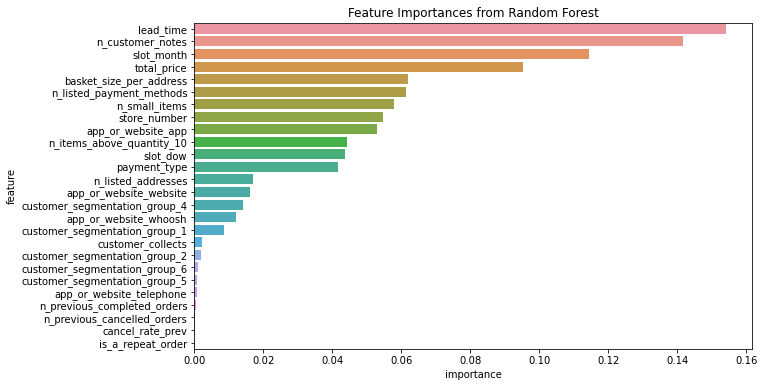

In [98]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame to view and sort the results
feature_df = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_df)
plt.title('Feature Importances from Random Forest')
plt.show()

The feature importance results show that lead_time, n_customer_notes, slot_month, and total_price are the strongest predictors of cancellation behavior, highlighting temporal and behavioral factors. Basket-related ratios and operational details such as listed payment methods and store_number also contribute significantly, while historical order patterns (previous cancellations/completions) and repeat order flags play a minimal role, suggesting customer context outweighs past order history in this dataset.

### Ensembling and threshold selection

In this step, I built an ensemble by combining LightGBM and Logistic Regression using weighted soft voting. Ensembling blends predictions from multiple models to leverage their strengths. Logistic Regression was given higher weight for its strong recall, while LightGBM contributed balanced performance with the highest F1 score. A custom threshold (0.4) further optimized recall.

In [64]:
# Assign model weights for soft voting
# (higher for LR since it has higher recall)
w_lgbm, w_lr = 0.2, 0.8   

# Compute weighted average of predicted probabilities from both models
p_avg = (w_lgbm * lgbm_probs + w_lr * lr_probs) / (w_lgbm + w_lr)

# Apply a custom classification threshold (0.4 instead of default 0.5)
y_pred_f1 = (p_avg >= 0.4).astype(int)

# Evaluate ensemble performance using Macro F1 score
ensemble_f1m = f1_score(y_val_processed, y_pred_f1, average='macro')
print(f'f1_score: {ensemble_f1m:.2f}')


# Calculate recall for the positive (minority) class
ensemble_recall = recall_score(y_val_processed, y_pred_f1)

print(f"Recall score: {ensemble_recall:.2f}")

f1_score: 0.57
Recall score: 0.70


## Predictions

In [65]:
# Make a copy of the test dataset to avoid modifying the original
test_df = test.copy()

# Set the 'id' column as the index for easier tracking of predictions
test_df = test_df.set_index('id')

# Apply the preprocessing pipeline to the test dataset
test_df_processed, test_y =process_data(test_df, None, most_frequent_segment, columns_to_scale, frequency_map, payment_mapping, target_mapping)

# Generate class probabilities from LightGBM and Logistic Regression models
pt_lgbm = lgbm_model.predict_proba(test_df_processed)[:, 1]
pt_lr   = lr_model.predict_proba(test_df_processed)[:, 1]

# # Combine probabilities using weighted soft voting
pt_avg = (w_lgbm * pt_lgbm + w_lr * pt_lr) / (w_lgbm + w_lr)

# Apply the tuned decision threshold (0.4 instead of default 0.5)
test_pred_f1 = (pt_avg >= 0.4).astype(int)

# Invert the mapping
reverse_mapping = {v: k for k, v in target_mapping.items()}

# Map predicted numeric values to original labels (e.g., 1 -> "Canceled", 0 -> "Not_Canceled")
y_pred_labels = pd.Series(test_pred_f1).map(reverse_mapping)

# Add the predictions back to the original test dataset under the 'status' column
test['status'] = y_pred_labels

In [66]:
test.head()

,id,app_or_website,customer_collects,customer_segmentation,is_a_repeat_order,lead_time,n_customer_notes,n_items_above_quantity_10,n_listed_addresses,n_listed_payment_methods,n_previous_cancelled_orders,n_previous_completed_orders,n_small_items,payment_type,slot_date,store_number,total_price,status
0,TID27662,app,0.0,group_1,0.0,307.941244,0.0,0.0,1.0,2.0,0.0,0.0,2.0,debit,2019-11-02 00:00:00,id_52,33.614758,Not_Canceled
1,TID15406,app,0.0,group_1,0.0,92.981607,0.0,1.0,1.0,3.0,0.0,0.0,1.0,debit,2019-11-17 00:00:00,id_1,55.400958,Not_Canceled
2,TID22875,website,NaN,group_1,0.0,26.147605,1.0,1.0,1.0,1.0,0.0,0.0,1.0,debit,2019-10-15 00:00:00,id_69,85.462568,Not_Canceled
3,TID05951,app,NaN,group_1,0.0,67.411008,0.0,2.0,1.0,2.0,0.0,0.0,2.0,debit,2019-11-09 00:00:00,id_79,46.157736,Not_Canceled
4,TID07762,website,0.0,group_1,0.0,258.465182,2.0,1.0,1.0,2.0,0.0,0.0,4.0,debit,2019-12-05 00:00:00,id_7,79.282073,Not_Canceled


In [67]:
test.to_csv('data/order_cancellation_prediction.csv')

## Conclusion
In this project, I developed machine learning models to predict order cancellations. Through comparative evaluation, `Logistic Regression` showed the highest recall, making it effective at capturing minority cancellation cases, while `LightGBM` achieved the best F1 score, balancing precision and recall. To leverage both strengths, I applied a `weighted soft voting ensemble` with threshold tuning, which improved recall without substantially sacrificing F1.

## Future Work

 - `Threshold optimization`: Systematically tune decision thresholds across models to balance recall and precision for specific business needs.

 - `Advanced ensembling`: Explore stacking combining diverse models beyond LR and LightGBM.

 - `Feature engineering`: Enrich features using customer history, seasonal effects, or external data (e.g., holidays, promotions).

 - `Real-time deployment`: Integrate the model into production with monitoring to handle data drift and evolving cancellation behavior.
